In [2]:
import torch
from torch import nn
from torchsummary import summary as summary_
from torch.nn import functional as F
import torch.nn.utils.prune as prune

## Model


In [3]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()

## Profiling: parameter

In [4]:
summary_(model,(1,28,28),batch_size=10)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [10, 32, 28, 28]             832
            Conv2d-2           [10, 64, 14, 14]          51,264
            Linear-3                 [10, 1024]       3,212,288
            Linear-4                   [10, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 2.95
Params size (MB): 12.49
Estimated Total Size (MB): 15.47
----------------------------------------------------------------


<ipython-input-3-38b99789a436>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


## Profiler: torch-sensor
- reference: https://github.com/parrt/tensor-sensor


In [8]:
!pip install tensor-sensor

  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
  Created wheel for tensor-sensor: filename=tensor_sensor-0.1.1-py3-none-any.whl size=24320 sha256=67ff682c5af8b41b0be379cbe14f01d2b6ec06c690dae7137d4711af48c4e9bb
  Stored in directory: /Users/jeong-ighyo/Library/Caches/pip/wheels/c6/ef/d6/42742e5204f39c0f3a51edf3becebc5f4e1c1a5d55e703df01
Successfully built tensor-sensor
  Attempting uninstall: parso
    Found existing installation: parso 0.8.1
    Uninstalling parso-0.8.1:
      Successfully uninstalled parso-0.8.1


In [12]:
import torch
import tsensor
import sys
import numpy as np

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

[[ 9]
 [10]]


findfont: Font family ['Consolas'] not found. Falling back to DejaVu Sans.


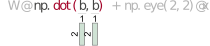

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [10]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

In [48]:
import tsensor
import torch
import sys


#b = torch.tensor([9, 10]).reshape((1, 2))
b = torch.tensor([9, 10])
_b = torch.tensor([9, 10]).reshape((2, 1))

In [49]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
       print(torch.dot(b, b))
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

tensor(181)


In [52]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
       print(torch.matmul(b, _b))
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

tensor([181])


## pytorch profiler

- reference: https://pytorch.org/tutorials/recipes/recipes/profiler.html

In [53]:
import torch
import torchvision.models as models
import torch.autograd.profiler as profiler

In [54]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

In [55]:
with profiler.profile(record_shapes=True) as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

In [56]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        14.33%      87.059ms       100.00%     607.414ms     607.414ms             1  
                     aten::conv2d         0.02%     132.278us        40.52%     246.110ms      12.306ms            20  
                aten::convolution         0.02%     134.677us        40.49%     245.978ms      12.299ms            20  
               aten::_convolution         0.08%     510.426us        40.47%     245.843ms      12.292ms            20  
         aten::mkldnn_convolution        40.35%     245.134ms        40.38%     245.304ms      12.265ms            20  
        aten::adaptive_avg_pool2d       

In [58]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                   Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                  model_inference        14.33%      87.059ms       100.00%     607.414ms     607.414ms             1                                             []  
        aten::adaptive_avg_pool2d         0.06%     391.410us        20.45%     124.245ms     124.245ms             1                           [[5, 512, 7, 7], []]  
                       aten::mean         3.81%      23.165ms        20.39%     123.854ms     123.854ms             1                   [[5, 512, 7, 7], [], [], []] 

In [59]:
with profiler.profile(profile_memory=True, record_shapes=True) as prof:
    model(inputs)

print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         0.13%     366.141us         0.13%     366.141us       2.953us      94.79 Mb      94.79 Mb           124  
                    aten::resize_         0.01%      16.919us         0.01%      16.919us       8.459us      11.48 Mb      11.48 Mb             2  
                      aten::addmm         0.08%     247.441us         0.09%     261.289us     261.289us      19.53 Kb      19.53 Kb             1  
              aten::empty_strided         0.00%       2.684us         0.00%       2.684us       2.684us         

In [61]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::zeros         0.00%       7.009us         0.01%      20.140us      20.140us             1  
                      aten::empty         0.11%     313.129us         0.11%     313.129us       2.485us           126  
                      aten::zero_         0.00%       1.974us         0.00%       6.237us       6.237us             1  
                      aten::fill_         0.00%       7.018us         0.00%       7.018us       3.509us             2  
                  model_inference         3.86%      11.190ms        99.99%     289.732ms     289.732ms             1  
                     aten::conv2d       

In [60]:
with profiler.profile() as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

prof.export_chrome_trace("/trace.json")

OSError: [Errno 30] Read-only file system: '/trace.json'

In [ ]:
prof.export_chrome_trace("/trace.json")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with profiler.profile() as prof:
    with profiler.record_function("model_inference"):
        model(inputs)

prof.export_chrome_trace("/content/gdrive/MyDrive/trace.json")